In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load test samples
from tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("test_samples/samples_1.pickle")

from covariance import optimise_pr_cg, points_at_iteration, logX_covinv_chol, logX_mu, logX_covinv_rud, X_logL
from plotting import plot_fit_raw

### **TODO**
- Use just the dead points **DONE**\
Least-squares seems to fit better than correlated gaussian, again worrying. Inverse covariance matrix seems to have very large mixing between neighbouring points.
- Create functions for covariance/mean which depend on a general live point distribution **DONE**
- Use both dead and live points using above live point distribution **DONE**

- Figure out termination conditions for gaussian/correlated gaussian samples so that I can check the value of $X_\text{end}$ I infer is correct. In correlated gaussian samples use condition based on KLD - how does this square with reaching threshold prior mass?

- Do covariance fit on few data points to have better sense of what is going on. 
- Plot error bars corresponding to covariance matrix


Tools:
- Visualise distribution of X in live points used **DONE**

- Plot contours in $d$,  $\sigma$ to show global minimum is found, given some bounds for the parameters **DONE**

#### Function to calculate mean and covariance for exact live point distributions

Matching matrices from Cholesky and direct methods, should be correct. Mean diverges from samples.logX() slightly, especially towards the end, likely due to samples.logX() using approximation.

In [ ]:
iteration = 1000
nlive = 500
points = points_at_iteration(samples_g_1, iteration)
logL = points.logL
nk = np.array(points.nlive)

In [ ]:
((logX_mu(np.array(points.nlive)) - points.logX())/points.logX())[:-100].plot()
plt.title("Fractional difference in logX_mu vs samples.logX()");

In [ ]:
covinv_chol = logX_covinv_chol(nk)
covinv_rud = logX_covinv_rud(nk)
(covinv_chol - covinv_rud).max()

5.8119553614233896e-08

#### Fitting pure Gaussian

##### Only using dead points

In [14]:
# Check that the pure gaussian samples have a pure gaussian L(X) i.e. fit our model exactly by inferring d, sigma using LS
# As iteration number increases, the estimates for d, sigma become more accurate

from lm_full import levenberg_marquardt
from plotting import plot_fit_raw

iteration = 1000
points = points_at_iteration(samples_g_1, iteration)
points_dead = points.iloc[:iteration]
Xdead, logLdead = X_logL(points_dead)

<AxesSubplot: xlabel='None'>

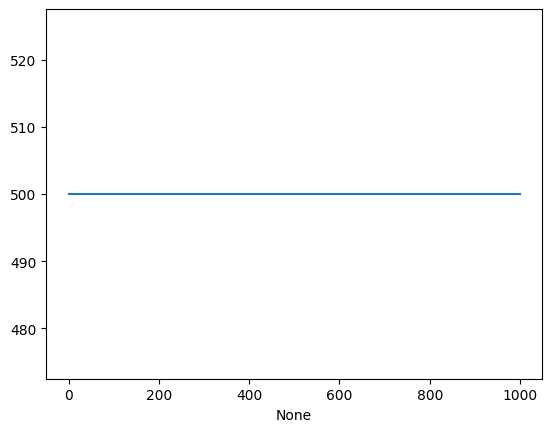

In [11]:
points_dead.nlive.plot()

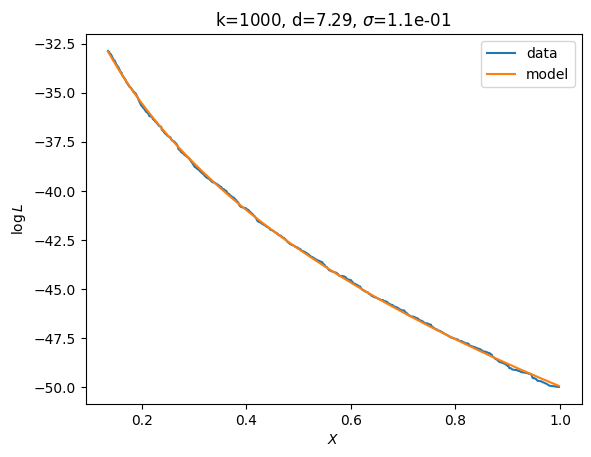

In [10]:
params = levenberg_marquardt(logLdead, Xdead, [-1, 10, 0.1]).x
plot_fit_raw(Xdead, logLdead, params)

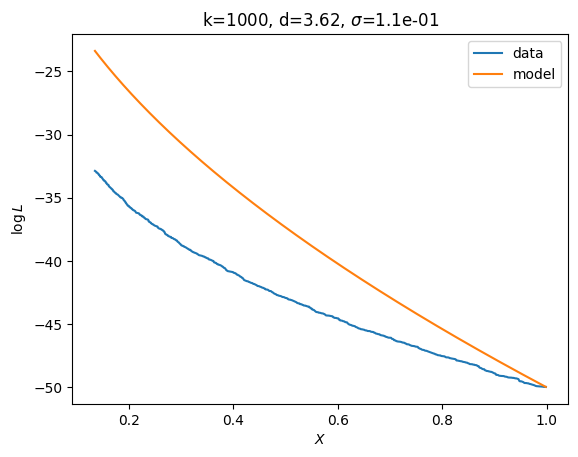

In [6]:
nk_dead = np.array(points_dead.nlive)
mean = logX_mu(nk_dead)
covinv = logX_covinv_chol(nk_dead)
params = optimise_pr_cg(logLdead, mean, covinv, [-0.1, 10, 0.1]).x
plot_fit_raw(Xdead, logLdead, params)

##### Now using both live and dead points

<AxesSubplot: xlabel='None'>

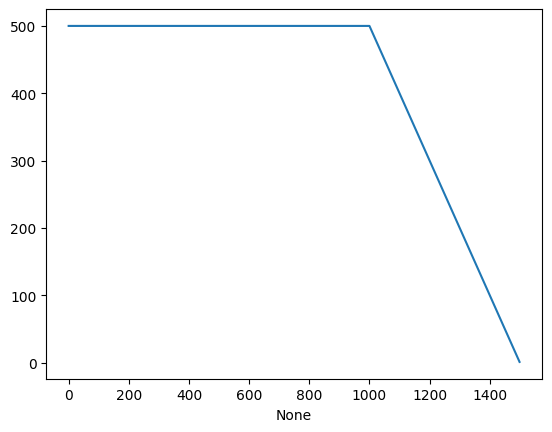

In [8]:
points.nlive.plot()

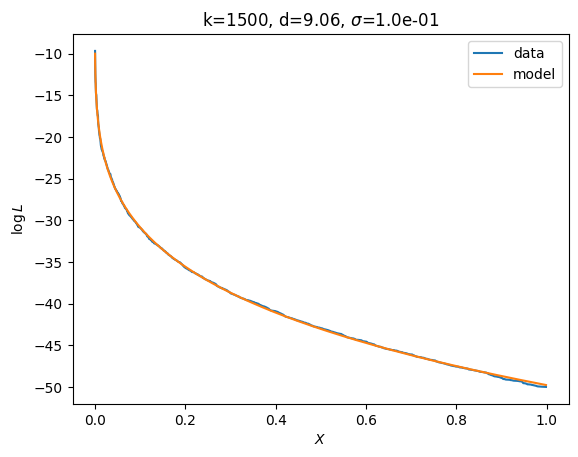

In [15]:
X, logL = X_logL(points)
params = levenberg_marquardt(logL, X, [-1, 10, 0.1]).x
plot_fit_raw(X, logL, params)

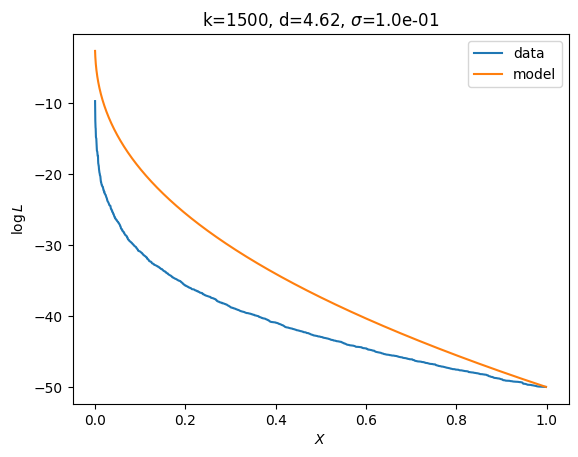

In [7]:
nk = np.array(points.nlive)
mean = logX_mu(nk)
covinv = logX_covinv_chol(nk)
params = optimise_pr_cg(logL, mean, covinv, [-0.1, 10, 0.1]).x
plot_fit_raw(X, logL, params)

#### Visualise distribution of X used

Want an easy way to check whether the distribution of points in X. Do we want uniform in X or logX? Result is dead points are uniform in logX, live points decreasing

In [249]:
def plot_likelihood(points, ndead, **kwargs):
    """Plots logL against X for a set of samples"""
    ls = kwargs.get("ls", '-')
    ms = kwargs.get("ms", .5)
    axv = kwargs.get("avx", False)

    nk = np.array(points.nlive)
    X, logL = X_logL(points)
    plt.plot(X, logL, ls, ms=ms)
    if axv:
        plt.axvline(x=X[ndead], ls='--')
    plt.xlabel("$X$")
    plt.ylabel("$\log L$")


def points_distribution(points, bins=100):
    """Plots distribution of X in a set of samples"""
    X, logL = X_logL(points)
    fig, ax = plt.subplots(1, 2, figsize=(6,2), dpi=200)
    ax[0].hist(X, bins=bins, histtype="step")
    ax[0].set_xlabel("X")
    ax[1].hist(np.log(X), bins=bins, histtype="step")
    ax[1].set_xlabel("logX")

In [ ]:
iteration = 5000
points = points_at_iteration(samples_g_1, iteration)
points_distribution(points)

In [ ]:
# Plot dead + live points at middle of run vs at end of the run
plt.figure(figsize=(12,5), dpi=150)
plot_likelihood(samples_g_1, len(samples_g_1)-1)
plot_likelihood(points, iteration, ls="x", ms=2, axv=True)

#### Contours

In [8]:
from covariance import brute
from plotting import contours

iteration = 1000
points = points_at_iteration(samples_g_1, iteration)
logL = np.array(points.logL)

nk = np.array(points.nlive)
mean = logX_mu(nk)
covinv = logX_covinv_chol(nk)
covinv_ls = np.diag(np.ones_like(mean))

In [12]:
grids_ls = brute(logL, mean, covinv_ls, 20)
contours(grids_ls)

interactive(children=(IntSlider(value=0, description='logLmax_index', max=19), Output()), _dom_classes=('widge…

In [13]:
grids_cg = brute(logL, mean, covinv_ls, 20)
contours(grids_cg)

interactive(children=(IntSlider(value=0, description='logLmax_index', max=19), Output()), _dom_classes=('widge…